National Research University "Higher School of Economics"

Master of Data Science Online Programme

Course: Introduction to Deep Learning

Final Project: Computer Vision (Part 1)

Student: Andrei Batyrov (Fall2022)

Date: 14-Nov-2023

##### Table of Contents

[Description](#description)

[Part 1: Computer Vision](#cv)

1. [Data Analysis](#data-analysis)

2. [ResNet](#resnet)

3. [ViT](#vit)

4. [Summary](#summary)

In [33]:
# Essential import
import gc
import json
from pathlib import Path
import torch
import torchvision
from torchvision import transforms
from torchvision import models
from transformers import ViTImageProcessor, ViTForImageClassification
import numpy as np
from PIL import Image
import requests
#from sklearn.metrics import accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
epochs = 10 # Number of epochs to train
seed = 13
batch_size = 384 # Train on this many images per batch
torch.manual_seed(seed=seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'{device = }')

device = device(type='cuda')


Some helper functions.

In [2]:
def test_model(model, test_dataset, verbose=False):
    '''
    Compute mean accuracy of the `model` on the given `test_dataset` over all batches.
    '''
    # 1. Switch to eval mode
    model.model.eval()

    # 2. Apply transform to `test_dataset`. Note: this will change the actual dataset's transform, so copy first.
    _test_transform = test_dataset.transform
    test_dataset.transform = model.transform
    # Create data loader
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    
    # 3. Do eval loop for all batches
    accs = []
    n_batches_to_show = np.ceil(len(test_loader) / 10)
    with torch.no_grad():
        for i, data in tqdm(enumerate(test_loader), total=len(test_loader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model.model(inputs)
            # For `vit` we need to extract the `logits` tensor with predictions; for `resnet` the outputs are directly the tensor with predictions.
            if isinstance(model.model, ViTForImageClassification):
                outputs = outputs.logits
            acc = torch.mean(outputs.argmax(axis=1) == labels, dtype=float)
            accs.append(acc.item())
            if verbose:
                if i % n_batches_to_show == 0:
                    print(f'Batch: {i:>3}, Accuracy: {acc:.2f}')
    
    # 4. Restore transform
    test_dataset.transform = _test_transform
    return np.mean(accs)

In [3]:
def save_metrics(model_name:str, **metrics):
    '''
    Dump train/val loss and accuracy lists to a json file.
    '''
    with open(f'./metrics/{model_name}.json', 'w') as fh:
        json.dump(metrics, fh)

In [4]:
def load_metrics(model_name:str):
    '''
    Load train/val loss and accuracy lists from a json file.
    '''
    try:
        with open(f'./metrics/{model_name}.json', 'r') as fh:
            return json.load(fh)
    except:
        raise RuntimeError(f'The metrics json file not found or cannot be loaded. Was the model `{model_name}` trained?')

In [5]:
def train_model(model, train_subset, val_subset):
    if not model.is_trained:
        print(f'Training model `{model.name}`.')
        lr = 1e-3
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.model.parameters(), lr=lr)
        model.train(train_subset, val_subset, criterion, optimizer, epochs)
        model.is_trained = True
        # Save model's state and train/val metrics to disk
        torch.save(model.model.state_dict(), f'./models/{model.name}.pt')
        save_metrics(model.name, train_losses=model.train_losses, val_losses=model.val_losses, train_accs=model.train_accs, val_accs=model.val_accs)
        print('Model successfully trained and saved to disk.')
    else:
        print('Model is already trained.')

In [6]:
def load_model(model):
    '''
    Try to find and load our fine-tuned model.
    '''
    try:
        model.model.load_state_dict(torch.load(f'./models/{model.name}.pt'))
        model.model = model.model.to(device)
        model.is_trained = True
        print(f'Found fine-tuned model `{model.name}.pt`. Ready for inferring/testing.')
    except:
        print(f'Fine-tuned model `{model.name}` not found or cannot be loaded. Train/eval the model first.')

In [7]:
def plot_metrics(model_name:str):
    '''
    Plot model's loss and accuracy metrics obtained during train/val over the number of epochs.
    '''
    metrics = load_metrics(model_name)
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), metrics['train_losses'], color='C0', label='Train')
    plt.plot(range(1, epochs+1), metrics['val_losses'], color='C1', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(range(1, epochs+1))
    plt.legend()
    plt.grid(lw=0.5)
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), metrics['train_accs'], color='C0', label='Train')
    plt.plot(range(1, epochs+1), metrics['val_accs'], color='C1', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xticks(range(1, epochs+1))
    plt.legend()
    plt.grid(lw=0.5)
    plt.suptitle(f'Train and validation datasets metrics: {model_name}', fontsize=11)
    plt.tight_layout();

---
# <a id="description"></a>Description of the final project

## Introduction

This project consists of two parts. The first part is devoted to Computer Vision and based on the first four weeks of the course. The second part is on Natural Language Processing and based on weeks 5 and 6. 


## Detailed Task Description

### <a id="cv"></a>Part 1: Computer Vision

In this part you are going to work with [FOOD-101](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/), which contains images of various types of food - 101 classes in total.
The dataset contains the "images" folder with images for each food class, and a "meta" folder with annotations divided into train and test subsets. Annotations are provided in two formats JSON and TXT. You can use any of them. In both cases, the annotation file contains a list of image paths for each food class.

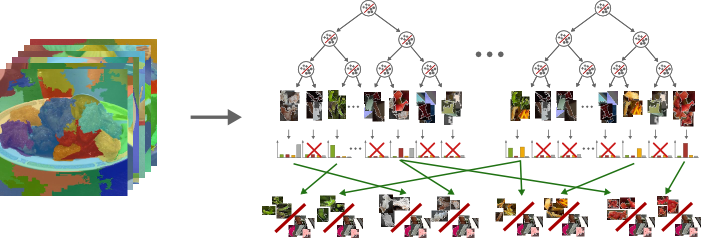

[Food-101 – Mining Discriminative Components with Random Forests](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf)

*Lukas Bossard, Matthieu Guillaumin, Luc Van Gool*

In this part of the task you should perform all the model training on train data and evaluate your models on test data. 

Use **[accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)** metric for scoring.

### <a id="data-analysis"></a>[5%] 1. Data analysis 


* 1.1  (3%) Download the [FOOD-101 dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/), visualize several examples from different classes and calculate basic statistics (example number, class distribution, etc.). 

**Note:** If you have limited computational resources, you can use only a subset of the original dataset which contains 10 or 50 classes. *There will be no punishment for this*. You can choose any classes you like from the original 101. If you decide to use fewer classes, please write this clearly in your solution and provide a reason for choosing this option.

In [8]:
food101_train = torchvision.datasets.Food101(root='./data', download=True, split='train', transform=None)
food101_test = torchvision.datasets.Food101(root='./data', download=True, split='test', transform=None)

First, check that the data was loaded correctly, and show some random 10 classes.

In [9]:
print(f'Number of food images all:      {len(food101_train)+len(food101_test):,} (100%)')
print(f'Number of food images in train:  {len(food101_train):,} ({len(food101_train)/len(food101_train+food101_test):.0%})')
print(f'Number of food images in test:   {len(food101_test):,} ({len(food101_test)/len(food101_train+food101_test):.0%})')
print(f'Number of food classes:             {len(food101_train.classes)} (100%)')
print('Random 10 classes (alphabetically sorted):')
print(sorted(np.array(food101_train.classes)[np.random.choice(len(food101_train.classes), 10, replace=False)]))

Number of food images all:      101,000 (100%)
Number of food images in train:  75,750 (75%)
Number of food images in test:   25,250 (25%)
Number of food classes:             101 (100%)
Random 10 classes (alphabetically sorted):
['beet_salad', 'bread_pudding', 'chicken_wings', 'garlic_bread', 'huevos_rancheros', 'ice_cream', 'lobster_bisque', 'prime_rib', 'spaghetti_bolognese', 'sushi']


Let's take a look at 25 random food images from the `train`. Note, that classes can repeat, but the images will be unique. This is interesting to see how different food items can look under the same class. Note, that the image brightness and contrast may look "weird", due to the applied transforms, as per the [documentation](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html#torchvision.models.resnet50).

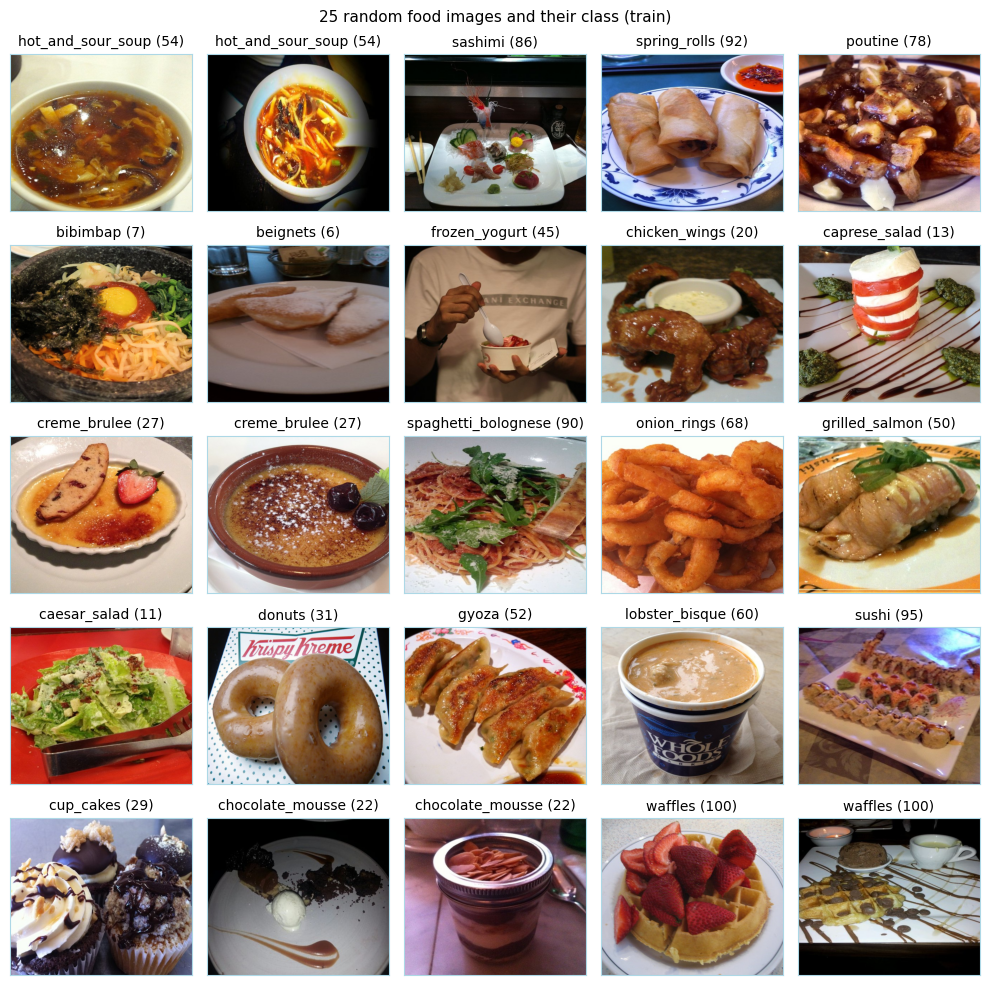

In [10]:
classes_by_idx = food101_train.class_to_idx
idxs = sorted(np.random.choice(len(food101_train), 25, replace=False))
fig = plt.figure(figsize=(10, 10))
ncols, nrows = 5, 5
for i in range(1, ncols * nrows + 1):
    img, class_idx = food101_train[idxs[i-1]]
    class_label = list(classes_by_idx.keys())[list(classes_by_idx.values()).index(class_idx)]
    fig.add_subplot(nrows, ncols, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.transpose(img, (0, 1, 2)).squeeze(), aspect='auto')
    plt.title(f'{class_label} ({class_idx})', fontsize=10)
    for axis in plt.gcf().get_axes():
        spines = axis.spines
        spines['bottom'].set_color('lightblue')
        spines['top'].set_color('lightblue')
        spines['right'].set_color('lightblue')
        spines['left'].set_color('lightblue')
plt.suptitle('25 random food images and their class (train)', fontsize=11)
plt.tight_layout()

Check one random image from the `test` too.

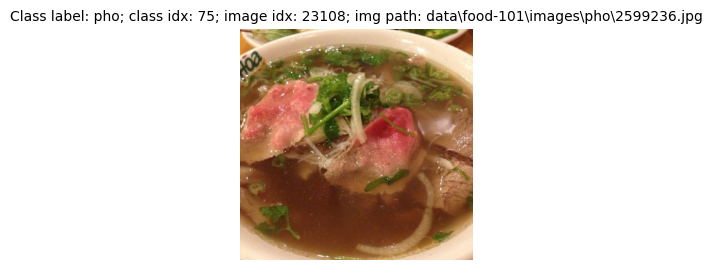

In [11]:
idx = np.random.choice(len(food101_test), 1)[0]
img, class_idx = food101_test[idx]
plt.figure(figsize=(3, 3))
plt.imshow(np.transpose(img, (0, 1, 2)).squeeze(), aspect='auto')
plt.title(f'Class label: {list(classes_by_idx.keys())[list(classes_by_idx.values()).index(class_idx)]}; class idx: {class_idx}; image idx: {idx}; img path: {food101_test._image_files[idx]}', fontsize=10)
plt.axis('off');

* 1.2  (2%) Split the data from train into `current_train` and `current_val` (`val_size = 10%`). Do not forget to fix `random_state` for reproducibility.

In [12]:
current_train, current_val = torch.utils.data.random_split(food101_train, lengths=[0.9, 0.1])

Check that the split was correct.

In [13]:
print(f'{"Current train and val count:":<36}{len(set(current_train.indices) | set(current_val.indices)):,} (100%)')
print(f'{"Current train count:":<36}{len(current_train):,} ({len(current_train)/len(food101_train):.0%})')
print(f'{"Current val count:":<37}{len(current_val):,} ({len(current_val)/len(food101_train):.0%})')
print(f'{"Current train and val intersection:":<41}{len(set(current_train.indices) & set(current_val.indices)):}')

Current train and val count:        75,750 (100%)
Current train count:                68,175 (90%)
Current val count:                   7,575 (10%)
Current train and val intersection:      0


### <a id="resnet"></a>[15%] 2. ResNet Fine-tuning
* 2.1   Take pre-trained [ResNet](https://pytorch.org/vision/main/models/resnet.html) from torchvision (you may take either `ResNet34` or `ResNet50` pre-trained on ImageNet).

First, let's create a model factory, which builds a new model based on some pre-trained one, but with the untrained last classification layer. We will use it both for ResNet and ViT models. We will also train and validate our models with this factory.

In [14]:
class Food101Classifier:
    def __init__(self, base_model:str, verbose=False):
        # 1. Create an existing pre-trained model
        if base_model not in ('resnet34', 'resnet50', 'vit'):
            raise ValueError("base_model should be one of 'resnet34', 'resnet50', or 'vit'")
        if base_model == 'resnet34':
            # https://pytorch.org/vision/main/models/generated/torchvision.models.resnet34.html
            self.name = 'food101_resnet34'
            self.model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
            self.transform = models.ResNet34_Weights.IMAGENET1K_V1.transforms()
        elif base_model == 'resnet50':
            # https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html
            self.name = 'food101_resnet50'
            self.model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
            self.transform = models.ResNet50_Weights.DEFAULT.transforms()
        else: # base_model == 'vit'
            # https://huggingface.co/google/vit-base-patch16-224
            self.name = 'food101_vit'
            self.model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
            self.processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
            self.transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        # 2. Freeze all layers
        for param in self.model.parameters():
            param.requires_grad = False
        # 3. Replace the last layer (1000 ImageNet classes) with a new untrained layer (101 Food classes)
        out_features = 101
        if base_model == 'vit':
            in_features = self.model.classifier.in_features
            self.model.classifier = torch.nn.Linear(in_features, out_features)
        else: # base_model ~ 'resnet'
            in_features = self.model.fc.in_features
            self.model.fc = torch.nn.Linear(in_features, out_features)
        self.is_trained = False
        self.verbose = verbose
        self.model = self.model.to(device)

    def train(self, train_subset, val_subset, criterion, optimizer, epochs:int):
        # 1. Apply transform to `train_subset`. Note: this will change the actual parent dataset's transform, so 1) copy first, 2) no need to transform `val_subset`.
        _train_transform = train_subset.dataset.transform
        train_subset.dataset.transform = self.transform
        # 2. Create data loaders
        self.train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)
        self.val_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size, shuffle=True, num_workers=4)
        # 3. Store loss function and optimizer
        self.criterion = criterion
        self.optimizer = optimizer
        # 4. Do train and eval loop for the number of epochs
        self.train_losses, self.val_losses, self.train_accs, self.val_accs = [], [], [], []
        for epoch_i, _ in enumerate(range(epochs), start=1):
            print(f'-------------\nEpoch: {epoch_i:>2}/{epochs}')
            # Train one epoch
            self._train()
            # Eval one epoch
            self._validate()
        # 5. Restore transform
        train_subset.dataset.transform = _train_transform
    
    def _train(self):
        '''
        Train the classifier on all batches of the `train_loader` for one epoch.
        '''
        # 1. Switch to train mode
        self.model.train()

        # 2. Do train loop for all batches for one epoch
        print('\nTraining...')
        losses, accs = [], []
        n_batches_to_show = np.ceil(len(self.train_loader) / 10)
        for i, data in tqdm(enumerate(self.train_loader), total=len(self.train_loader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            # For `vit` we need to extract the `logits` tensor with predictions; for `resnet` the outputs are directly the tensor with predictions.
            if isinstance(self.model, ViTForImageClassification):
                outputs = outputs.logits
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()
            losses.append(loss.item())
            acc = torch.mean(outputs.argmax(axis=1) == labels, dtype=float)
            accs.append(acc.item())
            if self.verbose:
                if i % n_batches_to_show == 0:
                    print(f'Batch: {i:>4}, Train loss: {loss:.2f}, Train accuracy: {acc:.2f}')
        # 3. Keep and report train metrics for one epoch
        epoch_mean_loss = np.mean(losses)
        self.train_losses.append(epoch_mean_loss)
        epoch_mean_acc = np.mean(accs)
        self.train_accs.append(np.mean(epoch_mean_acc))
        print(f'Epoch avg: Train loss: {epoch_mean_loss:.2f}, Train accuracy: {epoch_mean_acc:.2f}')

    def _validate(self):
        '''
        Validate the classifier on all batches of the `val_loader` for one epoch.
        '''
        # 1. Switch to eval mode
        self.model.eval()

        # 2. Do eval loop
        print('\nEvaluating...')
        losses, accs = [], []
        n_batches_to_show = np.ceil(len(self.val_loader) / 10)
        with torch.no_grad():
            for i, data in tqdm(enumerate(self.val_loader), total=len(self.val_loader)):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = self.model(inputs)
                # For `vit` we need to extract the `logits` tensor with predictions; for `resnet` the outputs are directly the tensor with predictions.
                if isinstance(self.model, ViTForImageClassification):
                    outputs = outputs.logits
                loss = self.criterion(outputs, labels)
                losses.append(loss.item())
                acc = torch.mean(outputs.argmax(axis=1) == labels, dtype=float)
                accs.append(acc.item())
                if self.verbose:
                    if i % n_batches_to_show == 0:
                        print(f'Batch: {i:>3}, Val loss: {loss:.2f}, Val accuracy: {acc:.2f}')
        # 3. Keep and report val metrics for one epoch
        epoch_mean_loss = np.mean(losses)
        self.val_losses.append(epoch_mean_loss)
        epoch_mean_acc = np.mean(accs)
        self.val_accs.append(np.mean(epoch_mean_acc))
        print(f'Epoch avg: Val loss: {epoch_mean_loss:.2f}, Val accuracy: {epoch_mean_acc:.2f}')

In [38]:
# Create directories to store results
try:
    Path('./models').mkdir()
except Exception as e:
    print(str(e))
try:
    Path('./metrics').mkdir()
except Exception as e:
    print(str(e))

In [39]:
model_resnet50 = Food101Classifier(base_model='resnet50')
print(f'Parameters to fine-tune: {np.sum([param.numel() for param in model_resnet50.model.parameters() if param.requires_grad]):,}')
load_model(model_resnet50)
assert model_resnet50.model.fc.out_features == 101, 'The last classification layer must have 101 classes!'

Parameters to fine-tune: 206,949
Fine-tuned model `food101_resnet50` not found or cannot be loaded. Train/eval the model first.


What is the accuracy of the __untrained__ model on the `test`?

In [16]:
test_model(Food101Classifier(base_model='resnet50'), food101_test)

100%|██████████| 66/66 [01:16<00:00,  1.15s/it]


0.0077858324625566

No surprise, that the accuracy for the untrained model is so low.

* 2.2  (10%) Fine-tune pre-trained ResNet on `current_train` created in 1.2. Do not forget about validation on `current_val` created in 1.2 in process of training.

In [17]:
train_model(model_resnet50, current_train, current_val)

Training model `food101_resnet50`.
-------------
Epoch:  1/10

Training...


100%|██████████| 178/178 [02:56<00:00,  1.01it/s]


Epoch avg: Train loss: 3.18, Train accuracy: 0.39

Evaluating...


100%|██████████| 20/20 [00:19<00:00,  1.01it/s]


Epoch avg: Val loss: 2.41, Val accuracy: 0.50
-------------
Epoch:  2/10

Training...


100%|██████████| 178/178 [03:08<00:00,  1.06s/it]


Epoch avg: Train loss: 2.07, Train accuracy: 0.56

Evaluating...


100%|██████████| 20/20 [00:19<00:00,  1.00it/s]


Epoch avg: Val loss: 1.99, Val accuracy: 0.55
-------------
Epoch:  3/10

Training...


100%|██████████| 178/178 [02:53<00:00,  1.03it/s]


Epoch avg: Train loss: 1.73, Train accuracy: 0.61

Evaluating...


100%|██████████| 20/20 [00:18<00:00,  1.07it/s]


Epoch avg: Val loss: 1.80, Val accuracy: 0.58
-------------
Epoch:  4/10

Training...


100%|██████████| 178/178 [02:43<00:00,  1.09it/s]


Epoch avg: Train loss: 1.53, Train accuracy: 0.65

Evaluating...


100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


Epoch avg: Val loss: 1.71, Val accuracy: 0.59
-------------
Epoch:  5/10

Training...


100%|██████████| 178/178 [02:42<00:00,  1.10it/s]


Epoch avg: Train loss: 1.40, Train accuracy: 0.67

Evaluating...


100%|██████████| 20/20 [00:18<00:00,  1.08it/s]


Epoch avg: Val loss: 1.65, Val accuracy: 0.60
-------------
Epoch:  6/10

Training...


100%|██████████| 178/178 [02:46<00:00,  1.07it/s]


Epoch avg: Train loss: 1.31, Train accuracy: 0.69

Evaluating...


100%|██████████| 20/20 [00:18<00:00,  1.06it/s]


Epoch avg: Val loss: 1.61, Val accuracy: 0.61
-------------
Epoch:  7/10

Training...


100%|██████████| 178/178 [02:45<00:00,  1.08it/s]


Epoch avg: Train loss: 1.22, Train accuracy: 0.71

Evaluating...


100%|██████████| 20/20 [00:18<00:00,  1.06it/s]


Epoch avg: Val loss: 1.58, Val accuracy: 0.61
-------------
Epoch:  8/10

Training...


100%|██████████| 178/178 [02:44<00:00,  1.08it/s]


Epoch avg: Train loss: 1.16, Train accuracy: 0.73

Evaluating...


100%|██████████| 20/20 [00:18<00:00,  1.07it/s]


Epoch avg: Val loss: 1.55, Val accuracy: 0.61
-------------
Epoch:  9/10

Training...


100%|██████████| 178/178 [02:43<00:00,  1.09it/s]


Epoch avg: Train loss: 1.10, Train accuracy: 0.74

Evaluating...


100%|██████████| 20/20 [00:19<00:00,  1.05it/s]


Epoch avg: Val loss: 1.54, Val accuracy: 0.61
-------------
Epoch: 10/10

Training...


100%|██████████| 178/178 [02:43<00:00,  1.09it/s]


Epoch avg: Train loss: 1.05, Train accuracy: 0.75

Evaluating...


100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


Epoch avg: Val loss: 1.54, Val accuracy: 0.61
Model successfully trained and saved to disk.


Let's plot the metrics for the `current_train` and `current_val`.

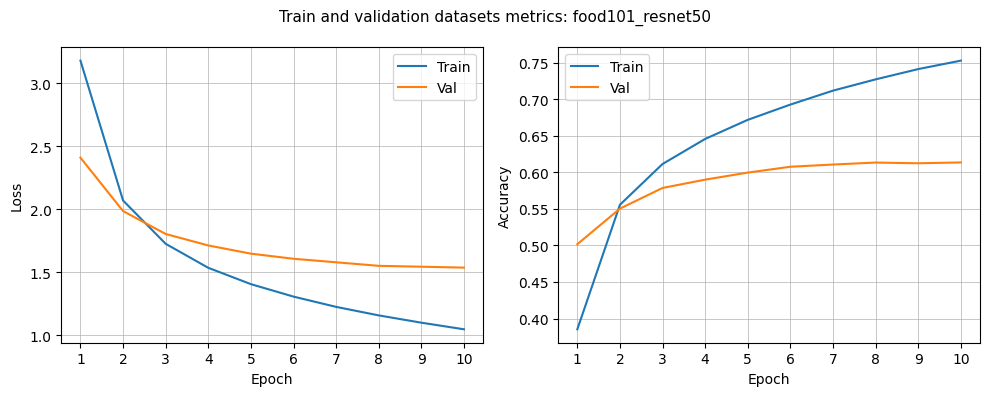

In [18]:
plot_metrics(model_resnet50.name)

We can confirm that the model was trained normally. The loss and accuracy curves have expected profiles for train and validation datasets. At the same time, we can see that the trained model overfits.

* 2.3  (5%) Evaluate your fine-tuned model (use accuracy metric and data from test part for the evaluation), analyze the results and make conclusions.

**Note:** If you decide to use only a subset of the food classes for model training, then you also only need to use the same classes from the test set for evaluation.

Finally, let's look at the accuracy of the __trained__ model on the `test`.

In [19]:
acc_test_resnet50 = test_model(model_resnet50, food101_test)

100%|██████████| 66/66 [00:57<00:00,  1.15it/s]


In [20]:
print(f'{acc_test_resnet50 = :.2%}')

acc_test_resnet50 = 66.36%


Now the model's accuracy $\approx$ 66% which is obviously much higher than before training. This is quite expected, since the model is trained now. Though this accuracy is not as high as for the ResNet50 model trained on ImageNet-1k (acc@1 $\approx$ 76-81%), still we were able to fine-tune a large model for our task within some reasonable time, instead of building a new model from the scratch or training the whole large model. In other words, we successfully applied the __transfer learning__ technique for our task.

In [21]:
# Done with this model, can clear the cuda cache now
torch.cuda.empty_cache()
gc.collect()

7978

### <a id="vit"></a>[20%] 3. Vit Fine-tuning
In this part you are going to fine-tune [ViT](https://huggingface.co/docs/transformers/model_doc/vit) model from HuggingFace library.
* 3.1   Study the [tutorial](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/image_classification.ipynb#scrollTo=X9DDujL0q1ac) on fine-tuning Vit model from transformers library.

**Note:** this part is not graded. However, you may find the material from the tutorial useful  for the successful completion of the task.
* 3.2  (5%) Take [Vit](https://huggingface.co/docs/transformers/model_doc/vit) model from HuggingFace library and initialize it with the [weights pre-trained on ImageNet](https://huggingface.co/google/vit-base-patch16-224).

In [22]:
model_vit = Food101Classifier(base_model='vit')
print(f'Parameters to fine-tune: {np.sum([param.numel() for param in model_vit.model.parameters() if param.requires_grad]):,}')
load_model(model_vit)
assert model_vit.model.classifier.out_features == 101, 'The last classification layer must have 101 classes!'

Parameters to fine-tune: 77,669
Fine-tuned model `food101_vit` not found or cannot be loaded. Train/eval the model first.


What is the accuracy of the __untrained__ model on the `test`?

In [23]:
test_model(Food101Classifier(base_model='vit'), food101_test)

100%|██████████| 66/66 [03:11<00:00,  2.91s/it]


0.0075352120341344465

No surprise, that the accuracy for the untrained model is so low.

* 3.3  (10%) Similarly to point 2, fine-tune this model on on `current_train` created in 1.2. Do not forget about validation on `current_val` created in 1.2 in process of training.

In [24]:
train_model(model_vit, current_train, current_val)

Training model `food101_vit`.
-------------
Epoch:  1/10

Training...


100%|██████████| 178/178 [08:38<00:00,  2.91s/it]


Epoch avg: Train loss: 1.26, Train accuracy: 0.71

Evaluating...


100%|██████████| 20/20 [00:59<00:00,  2.99s/it]


Epoch avg: Val loss: 0.80, Val accuracy: 0.79
-------------
Epoch:  2/10

Training...


100%|██████████| 178/178 [08:48<00:00,  2.97s/it]


Epoch avg: Train loss: 0.74, Train accuracy: 0.80

Evaluating...


100%|██████████| 20/20 [01:00<00:00,  3.05s/it]


Epoch avg: Val loss: 0.74, Val accuracy: 0.81
-------------
Epoch:  3/10

Training...


100%|██████████| 178/178 [08:42<00:00,  2.93s/it]


Epoch avg: Train loss: 0.66, Train accuracy: 0.82

Evaluating...


100%|██████████| 20/20 [00:58<00:00,  2.92s/it]


Epoch avg: Val loss: 0.71, Val accuracy: 0.81
-------------
Epoch:  4/10

Training...


100%|██████████| 178/178 [09:38<00:00,  3.25s/it]


Epoch avg: Train loss: 0.60, Train accuracy: 0.84

Evaluating...


100%|██████████| 20/20 [00:54<00:00,  2.73s/it]


Epoch avg: Val loss: 0.70, Val accuracy: 0.81
-------------
Epoch:  5/10

Training...


100%|██████████| 178/178 [08:32<00:00,  2.88s/it]


Epoch avg: Train loss: 0.56, Train accuracy: 0.85

Evaluating...


100%|██████████| 20/20 [00:57<00:00,  2.88s/it]


Epoch avg: Val loss: 0.70, Val accuracy: 0.81
-------------
Epoch:  6/10

Training...


100%|██████████| 178/178 [08:36<00:00,  2.90s/it]


Epoch avg: Train loss: 0.53, Train accuracy: 0.86

Evaluating...


100%|██████████| 20/20 [00:57<00:00,  2.88s/it]


Epoch avg: Val loss: 0.69, Val accuracy: 0.82
-------------
Epoch:  7/10

Training...


100%|██████████| 178/178 [08:37<00:00,  2.91s/it]


Epoch avg: Train loss: 0.50, Train accuracy: 0.86

Evaluating...


100%|██████████| 20/20 [00:57<00:00,  2.88s/it]


Epoch avg: Val loss: 0.70, Val accuracy: 0.81
-------------
Epoch:  8/10

Training...


100%|██████████| 178/178 [08:34<00:00,  2.89s/it]


Epoch avg: Train loss: 0.48, Train accuracy: 0.87

Evaluating...


100%|██████████| 20/20 [00:57<00:00,  2.88s/it]


Epoch avg: Val loss: 0.70, Val accuracy: 0.82
-------------
Epoch:  9/10

Training...


100%|██████████| 178/178 [08:35<00:00,  2.89s/it]


Epoch avg: Train loss: 0.46, Train accuracy: 0.88

Evaluating...


100%|██████████| 20/20 [00:57<00:00,  2.88s/it]


Epoch avg: Val loss: 0.70, Val accuracy: 0.82
-------------
Epoch: 10/10

Training...


100%|██████████| 178/178 [08:35<00:00,  2.89s/it]


Epoch avg: Train loss: 0.44, Train accuracy: 0.88

Evaluating...


100%|██████████| 20/20 [00:58<00:00,  2.91s/it]


Epoch avg: Val loss: 0.70, Val accuracy: 0.82
Model successfully trained and saved to disk.


Let's plot the metrics for the `current_train` and `current_val`.

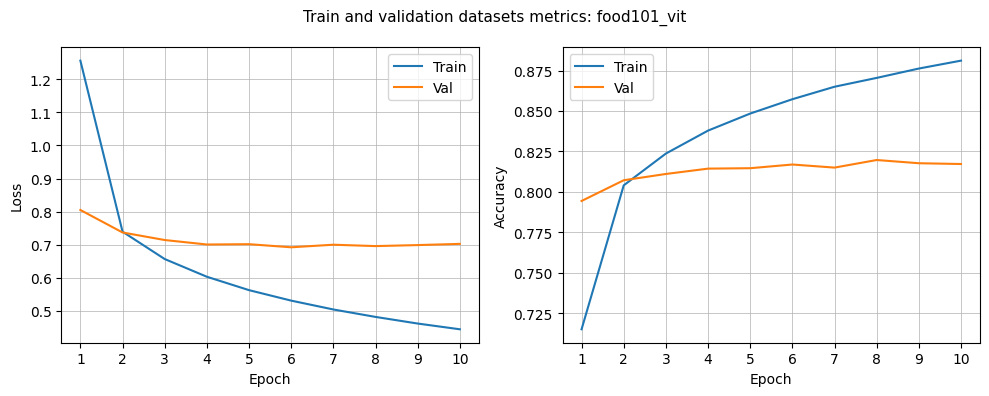

In [25]:
plot_metrics(model_vit.name)

We can confirm that the model was trained normally. The loss and accuracy curves have expected profiles for train and validation datasets. At the same time, we can see that the trained model overfits.

* 3.4  (5%) Evaluate your fine-tuned model (use accuracy metric and data from test part for the evaluation), analyze the results and make conclusions.

**Note** If you decide to use only a subset of the food classes for model training, then you also only need to use the same classes from the test set for evaluation.

Finally, let's look at the accuracy of the __trained__ model on the `test`.

In [26]:
acc_test_vit = test_model(model_vit, food101_test)

100%|██████████| 66/66 [03:14<00:00,  2.95s/it]


In [27]:
print(f'{acc_test_vit = :.2%}')

acc_test_vit = 85.64%


Now the model's accuracy $\approx$ 86% which is obviously much higher than before training. This is quite expected, since the model is trained now. Surprisingly, the accuracy is as high as for the ViT patch16-224 model fine-tuned on ImageNet-1k (acc@1 $\approx$ 85-90%). So, we successfully fine-tuned a large model for our task within some reasonable time, instead of building a new model from the scratch or training the whole large model. In other words, we successfully applied the __transfer learning__ technique for our task.

### <a id="summary"></a>[10%] 4. Summary & results analysis

* 4.1    (5%) Compare the results of the tested models. First, compare them between each other (ResNet vs ViT). Then with other models on [leaderboard](https://paperswithcode.com/sota/image-classification-on-food-101-1).

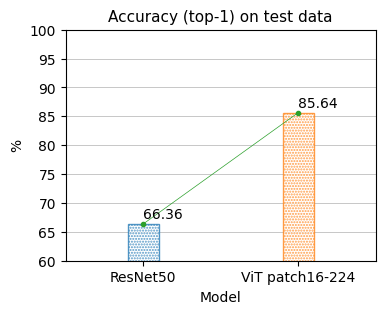

In [28]:
# Plot test accuracy for ResNet and Vit side by side
plt.figure(figsize=(4, 3))
plt.bar(['ResNet50', 'ViT patch16-224'], [acc_test_resnet50*100, acc_test_vit*100], color=['white', 'white'], edgecolor=['C0', 'C1'], width=0.2, hatch='.'*6, alpha=0.75)
plt.plot([acc_test_resnet50*100, acc_test_vit*100], marker='.', color='C2', lw=0.5)
plt.text('ResNet50', acc_test_resnet50*100+1, round(acc_test_resnet50*100, 2))
plt.text('ViT patch16-224', acc_test_vit*100+1, round(acc_test_vit*100, 2))
plt.xlim([-0.5, 1.5])
plt.ylim(60.0, 100.0)
plt.xlabel('Model')
plt.ylabel('%')
plt.title('Accuracy (top-1) on test data', fontsize=11)
plt.grid(axis='y', lw=0.5)
plt.gca().set_axisbelow(True);

We can see that the fine-tuned __ViT model is more accurate__ than the fine-tuned ResNet50 model. Now let's compare with other models from the [leaderboard](https://paperswithcode.com/sota/image-classification-on-food-101-1).

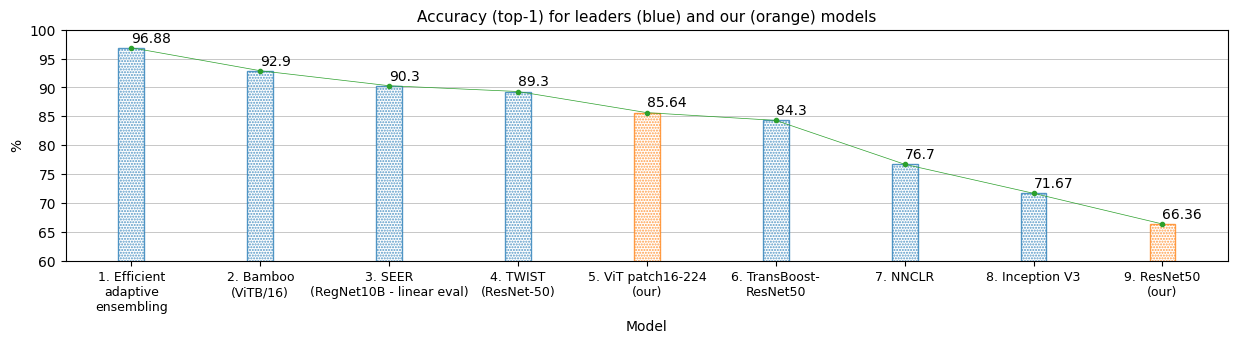

In [29]:
# Plot model accuracies side by side
accs = {'1. Efficient\nadaptive\nensembling': 96.88,
        '2. Bamboo\n(ViTB/16)': 92.90,
        '3. SEER\n(RegNet10B - linear eval)': 90.30,
        '4. TWIST\n(ResNet-50)': 89.30,
        '5. ViT patch16-224\n(our)': round(acc_test_vit*100, 2),
        '6. TransBoost-\nResNet50': 84.30,
        '7. NNCLR': 76.70,
        '8. Inception V3': 71.67,
        '9. ResNet50\n(our)': round(acc_test_resnet50*100, 2)}
plt.figure(figsize=(15, 3))
plt.bar(accs.keys(), accs.values(), color=['white']*9, edgecolor=['C0']*4+['C1']+['C0']*3+['C1'], width=0.2, hatch='.'*6, alpha=0.75)
plt.plot(accs.values(), marker='.', color='C2', lw=0.5)
for k, v in accs.items():
    plt.text(k, accs[k]+1, accs[k])
plt.xlabel('Model')
plt.ylabel('%')
plt.xticks(fontsize=9)
plt.ylim(60.0, 100.0)
plt.title('Accuracy (top-1) for leaders (blue) and our (orange) models', fontsize=11)
plt.grid(axis='y', lw=0.5)
plt.gca().set_axisbelow(True);

We can see that our ViT model can compete with other leaders, which is good. At the same time, our ResNet50 model is more of an outsider.

* 4.2    (5%) Propose, how you may improve the model score (write at least three ideas).

- Try other data transformations. We applied the default transformations, as per documentation for both models;
- Tune learning rate. During training / validation two learning rates were tested: 0.01 and 0.001, and eventually 0.001 was chosen as providing better accuracy;
- Try another optimizer, like Adagrad, Adadelta, etc. In this task only Adam was used;
- Try other models / architectures. We can see that on the same data ViT's accuracy is almost 20% higher than that of ResNet50; 
- Retrain the whole model(s) from the scratch, i.e. not only fine-tune the last classification layer (might be very expensive).

* 4.3 It is also interesting to see how our fine-tuned model performs on real unseen data. Since, the ViT model's accuracy is higher, let's infer several image class predictions with it. Let's download some 5 random food images from the Internet and try to classify them.

In [30]:
urls = ['https://www.recipetineats.com/wp-content/uploads/2018/07/Spaghetti-Bolognese.jpg',
        'https://www.recipetineats.com/wp-content/uploads/2023/08/Tuna-sandwich_2.jpg',
        'https://www.recipetineats.com/wp-content/uploads/2014/09/Mexican-Pizza-1.jpg',
        'https://www.recipetineats.com/wp-content/uploads/2017/03/Asian-Steak-3.jpg',
        'https://www.recipetineats.com/wp-content/uploads/2016/03/Tiramisu_5.jpg']
imgs = [Image.open(requests.get(url, stream=True).raw) for url in urls]

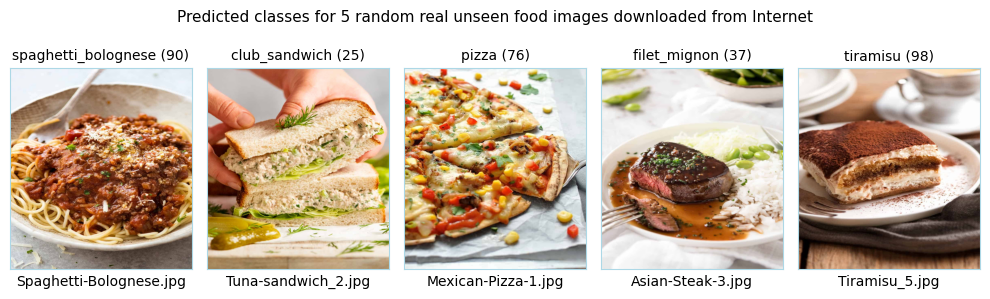

In [31]:
fig = plt.figure(figsize=(10, 3))
for i, img in enumerate(imgs, start=1):
    fig.add_subplot(1, 5, i)
    plt.imshow(img, aspect='auto')
    inputs = model_vit.processor(images=img, return_tensors='pt').to(device)
    outputs = model_vit.model(**inputs)
    logits = outputs.logits
    predicted_class_idx = logits.argmax(-1).item()
    plt.xlabel(urls[i-1].split('/')[-1]) # True
    plt.title(f'{list(classes_by_idx.keys())[list(classes_by_idx.values()).index(predicted_class_idx)]} ({predicted_class_idx})', fontsize=10) # Predicted
    plt.xticks([])
    plt.yticks([])
    for axis in plt.gcf().get_axes():
        spines = axis.spines
        spines['bottom'].set_color('lightblue')
        spines['top'].set_color('lightblue')
        spines['right'].set_color('lightblue')
        spines['left'].set_color('lightblue')
plt.suptitle('Predicted classes for 5 random real unseen food images downloaded from Internet', fontsize=11)
plt.tight_layout();

Not bad!

In [32]:
# Done with this model, can clear the cuda cache now
torch.cuda.empty_cache()
gc.collect()

65268

### General Requirements

* You should provide a solution in the form of the Jupyter Notebook with code cells and markdown cells (with text).
* Make sure that the instructor can run all the cells to reproduce your results.
* Clearly answer each question, perform the required actions from the task. Explain your decisions if you choose to use some techniques.
* Provide links to the tutorials you use for reference.

Sources:
- <a href="https://edu.hse.ru/course/view.php?id=182084">Introduction to Deep Learning</a>
- <a href="https://pytorch.org/vision/main/models/resnet.html">PyTorch - ResNet</a>
- <a href="https://huggingface.co/google/vit-base-patch16-224">Hugging Face - Vision Transformer</a>